<a href="https://colab.research.google.com/github/rory-smith/Lectures-on-inference-in-GW-astronomy/blob/master/GW_data_in_a_toy_universe.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
import requests, os
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina'


In [5]:
!pip install lalsuite

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [6]:
!pip install latex

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [7]:
import lalsimulation as lalsim
import numpy as np
from scipy import stats
import pylab as plt
import lal
#plt.rcParams['text.usetex'] = True

#plt.rcParams.update({
#    "text.usetex": True,
#   "font.family": "sans-serif",
#    "font.sans-serif": ["Helvetica"]})

In [8]:
def GW_detector_noise(N):


  deltaF = 1/4.
  noise_mean = 0
  noise_var = lalsim.SimNoisePSDaLIGOZeroDetLowPower(150) / (4*deltaF)

  noise_re = np.random.normal(loc=noise_mean, scale=np.sqrt(noise_var), size=int(N))
  noise_imag = np.random.normal(loc=noise_mean, scale=np.sqrt(noise_var), size=int(N))

  return noise_re + 1j*noise_imag

In [9]:
def prob_mtotal(N):

  mtot_min = 30
  mtot_max = 100
  mtot_mean = 60
  mtot_var = 10
  a = (mtot_min-mtot_mean)/np.sqrt(mtot_var) # some annoying parameter for scipy function
  b = (mtot_max-mtot_mean)/np.sqrt(mtot_var)
  return stats.truncnorm.rvs(a, b, loc=mtot_mean, scale=np.sqrt(mtot_var),size=int(N))

In [10]:
# this is all bookkeepy stuff to allow us to evaluate a GW signal at GW frequency of 150Hz #####
f = np.array([150])
F = f#np.loadtxt("Freqs_long.txt")
F = lal.CreateREAL8Vector(len(F))
F.data[:] =  f
###############################################################################
def GW_signal(Mtotal):

  mass_ratio = 1 #all binaries in our universe contain equal-mass black holes
  Dist = 1e5*lal.lal.PC_SI #all binary black holes are located 0.1Gpc from our detector
  spin1x, spin1y, spin1z = 0, 0, 0 #black holes do not spin in our Universe
  spin2x, spin2y, spin2z = 0, 0, 0 #black holes do not spin in our Universe
  iota = 0 #all BBH obits are inclined such that their orbital plane is "face on"

  m1, m2 = Mtotal/(1+mass_ratio), Mtotal/(1+mass_ratio)

  m1 *= lal.lal.MSUN_SI #component mass into SI units
  m2 *= lal.lal.MSUN_SI
  WFdict = lal.CreateDict() #bookkeepy thing
  h = lalsim.SimIMRPhenomXPHMFrequencySequence(F, m1, m2, spin1x, \
            spin1y, spin1z, spin2x, spin2y, spin2z, Dist, iota, 0, 150, WFdict)
  
  signal = h[0].data.data + h[1].data.data #equal parts plus and cross polarization
  return signal

In [11]:
GW_signal(30)

array([-2.12103602e-20+2.17551062e-23j])

In [13]:
noise_measurements = GW_detector_noise(1e4)

In [14]:
BBH_masses = prob_mtotal(1e4)

In [15]:
signals = np.array([GW_signal(_m) for _m in BBH_masses])

In [20]:
data_set = signals + noise_measurements

Text(0.5, 1.0, 'Probability density of BBH total mass $\\pi(M_{total})$')

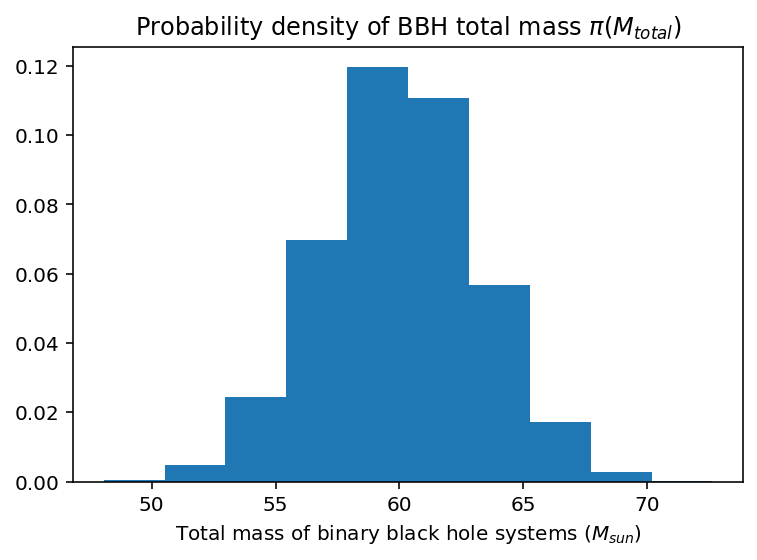

In [21]:
plt.hist(BBH_masses, density=True)
plt.xlabel(r"Total mass of binary black hole systems $(M_{sun})$")
plt.title(r"Probability density of BBH total mass $\pi(M_{total})$")

/usr/local/lib/python3.7/dist-packages/numpy/lib/histograms.py:905: ComplexWarning: Casting complex values to real discards the imaginary part
  db = np.array(np.diff(bin_edges), float)
/usr/local/lib/python3.7/dist-packages/matplotlib/transforms.py:789: ComplexWarning: Casting complex values to real discards the imaginary part
  points = np.array(args, dtype=float).reshape(2, 2)
/usr/local/lib/python3.7/dist-packages/matplotlib/transforms.py:1969: ComplexWarning: Casting complex values to real discards the imaginary part
  x, y = float(x), float(y)


KeyboardInterrupt: ignored

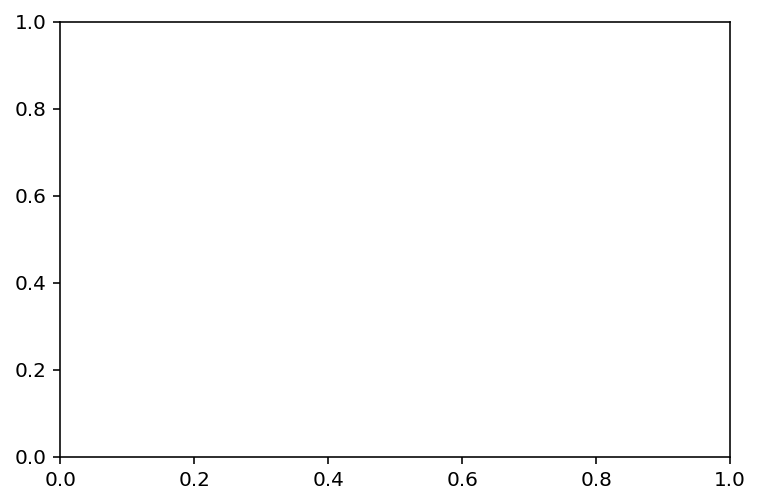

In [22]:
plt.hist(data_set, density=True, alpha=0.5,label="Data")
plt.hist(noise_measurements, density=True, alpha=0.5, label="noise")


In [19]:
signals[0] + noise_measurements[0]

array([-4.1453473e-20+2.10803857e-22j])

In [3]:
noise_measurements.shape